# UniversityHack 2021 - Atmira Stock Prediction - Script Producción
-----

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import keras
from keras import models
from keras import activations

from datetime import datetime
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
import gc
gc.collect()

20

In [3]:
# If you plan to run this notebook, it is recomended you have at least one GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Preprocessing

Before we do anything with our data, we perform an extensive data preprocessing step according to our EDA findings:

1. Drop the `antiguedad` variable as we do not find it contains sensible data.
2. Change the dates to the correct year we estimate the data is from to match the weekday periodicity missmatch.
3. Scale the visitas x5 for the period preceding 2019-1-24 as we've found that it was tampered with.
4. One-hot encode several fields to improve ML performance
5. Augment our data with weekday and monthly sin/cos periodicty helpers. Will help the ML system detect periodic patterns.

We also run a price filling algorithm on the `Modelar` dataset to fill in the Price of items as specified in the instructions.

In [10]:
def data_preprocessing_2(df):
    # General cleaning
    print('Dropping duplicates')
    df = df.drop_duplicates()
    df = df.drop(['antiguedad'], axis=1, errors='ignore')
    
    print('Fixing duplicate entries for campaign days')
    df = df.groupby(['fecha','id']).max().reset_index()
    
    print('Fixing dates')
    df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
    df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)
    
    print('Fixing visits')
    df['visitas_scl'] = np.where(
        df['fecha'] <= datetime(2019,1,24),
        df["visitas"] * 5,
        df["visitas"] * 1
    )
    df["visitas_scl"] = pd.to_numeric(df['visitas_scl'])
    
    # Data Augmentation
    df['dia_atipico_neg'] = (df.dia_atipico == -1).astype(int)
    df['dia_atipico_neu'] = (df.dia_atipico == 0).astype(int)
    df['dia_atipico_pos'] = (df.dia_atipico == 1).astype(int)

    df['estado_no_rotura'] = (df.estado == 'No Rotura').astype(int)
    df['estado_transito'] = (df.estado == 'Transito').astype(int)
    df['estado_rotura'] = (df.estado == 'Rotura').astype(int)
    
    # Drop the old columns
    df = df.drop(['estado', 'dia_atipico'], axis=1, errors='ignore')
    
    # Prepare categorias for Embedding
    df['categoria_uno'] = pd.Series(list(map(ord, df.categoria_uno))) - ord('A')+1
    df['categoria_dos'] = df.categoria_dos.fillna(0).astype(int)

    print('One-hot encoding of Category')
    df_categoria_uno_onehot = pd.get_dummies(df.categoria_uno, prefix='categoria_uno_')
    df_categoria_dos_onehot = pd.get_dummies(df.categoria_dos, prefix='categoria_dos_')
    
    df = pd.concat([df, df_categoria_uno_onehot, df_categoria_dos_onehot], axis=1)

    # Cyclical week and month spinners
    df_weekday = df.fecha.dt.weekday
    df_month = df["fecha"].dt.day / df["fecha"].dt.days_in_month
    df_year = (df["fecha"].dt.month - 1) + (df["fecha"].dt.day / df["fecha"].dt.days_in_month)
    
    df['weekday_sin'] = np.sin(df_weekday * (2*np.pi/7))
    df['weekday_cos'] = np.cos(df_weekday * (2*np.pi/7))
    df['month_sin'] = np.sin(df_month * (2*np.pi))
    df['month_cos'] = np.cos(df_month * (2*np.pi))
    df['year_sin'] = np.sin((df_year-1) * (2*np.pi/12))
    df['year_cos'] = np.cos((df_year-1) * (2*np.pi/12))
    
    print('clearing NANs')
    df.dropna(how='any', inplace=True)
    
    return df

def data_preprocessing_fill_price(df):
    total = len(df.id.unique())

    for i, pid in enumerate(df.id.unique()):
        # This product's entries
        df_prod = df[df.id == pid]

        # Fillforward, then back to cover the first few lines
        df_prod = df_prod.fillna(method='ffill').fillna(method='bfill')

        # Save to DF
        df.loc[df_prod.index] = df_prod

        clear_output(wait=True)
        print("Filled %.1f%% of the Dataframe" % (i/total * 100))
        
    return df
        

### Data Loading

We will be loading both ESTIMAR and MODELAR files here. Steps to load:

1. Read the raw file with pandas
2. For Modelar:
    1. Fill the price
    2. Apply data preprocessing
3. For Estimar:
    1. Apply data preprocessing
    
Our data preprocessing step will create some useful features as well as transform some columns to ONE HOT encoding, such as categories. After the process is done, we will have two identically-shaped dataframes (except for `unidades_vendidas`). This will make our life easier later on.

In [11]:
df_modelar = pd.read_csv('./data/Modelar_UH2021.txt', sep='|', parse_dates=[0])
df_modelar = data_preprocessing_fill_price(df_modelar)

Filled 100.0% of the Dataframe


In [13]:
# Pre-filled data
# df_modelar = pd.read_csv('./data/Modelar_UH2021_filled_precio_2.txt', sep='|', parse_dates=[0])

print(df_modelar.shape)
df_modelar = data_preprocessing_2(df_modelar)
print(df_modelar.shape)
df_modelar[:5]

(4045022, 11)
Dropping duplicates
Fixing duplicate entries for campaign days
Fixing dates
Fixing visits
One-hot encoding of Category
clearing NANs
(2029816, 217)


,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,unidades_vendidas,visitas_scl,dia_atipico_neg,...,categoria_dos__340,categoria_dos__341,categoria_dos__342,categoria_dos__343,weekday_sin,weekday_cos,month_sin,month_cos,year_sin,year_cos
0,2018-06-01,21972,0,3,75,5.84,0,0,0,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038
1,2018-06-01,23910,5,3,170,6.07,0,3,25,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038
2,2018-06-01,24306,13,1,46,7.85,0,0,65,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038
3,2018-06-01,27144,15,5,230,6.12,0,0,75,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038
4,2018-06-01,27504,7,3,157,10.74,0,0,35,0,...,0,0,0,0,-0.433884,-0.900969,0.207912,0.978148,0.857167,-0.515038


In [88]:
df_estimar = pd.read_csv('./data/Estimar2.txt', parse_dates=[0], sep='|', decimal=',', engine="python")
df_estimar['categoria_dos'] = df_estimar.categoria_dos.replace('-','0')

print(df_estimar.shape)
df_estimar = data_preprocessing_2(df_estimar)
print(df_estimar.shape)

df_estimar[:5]

(212841, 10)
Dropping duplicates
Fixing duplicate entries for campaign days
Fixing dates
Fixing visits
One-hot encoding of Category
clearing NANs
(212841, 197)


,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,visitas_scl,dia_atipico_neg,dia_atipico_neu,...,categoria_dos__340,categoria_dos__341,categoria_dos__342,categoria_dos__343,weekday_sin,weekday_cos,month_sin,month_cos,year_sin,year_cos
0,2019-10-01,21972,5,3,75,5.84,0,5,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302
1,2019-10-01,23910,35,3,170,6.07,0,35,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302
2,2019-10-01,27144,105,5,230,5.92,0,105,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302
3,2019-10-01,30014,25,3,63,5.84,0,25,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302
4,2019-10-01,30522,25,3,76,7.41,0,25,0,1,...,0,0,0,0,0.781831,0.62349,0.201299,0.97953,-0.874347,-0.485302


### Select all columns that appear in both DataFrames

Since not all categories appear in `Estimar`, we perform a set intersect to grab the matching columns. After this we are finally ready to build our model.

In [89]:
df_modelar_columns = set(df_modelar.columns)
df_estimar_columns = set(df_estimar.columns)
df_common_columns = df_modelar_columns & df_estimar_columns

# Reorder fecha to first column
df_common_columns.remove('fecha')

df_modelar = df_modelar[['fecha'] + list(df_common_columns) + ['unidades_vendidas']]
df_estimar = df_estimar[['fecha'] + list(df_common_columns)]

In [90]:
df_modelar.to_csv('data/Modelar_UH2021_prod.txt', index=False)
df_estimar.to_csv('data/Estimar2_prod.txt', index=False)

### Load pre-compiled data here

In [14]:
df_modelar = pd.read_csv('data/Modelar_UH2021_prod.txt', parse_dates=[0])
df_estimar = pd.read_csv('data/Estimar2_prod.txt', parse_dates=[0])

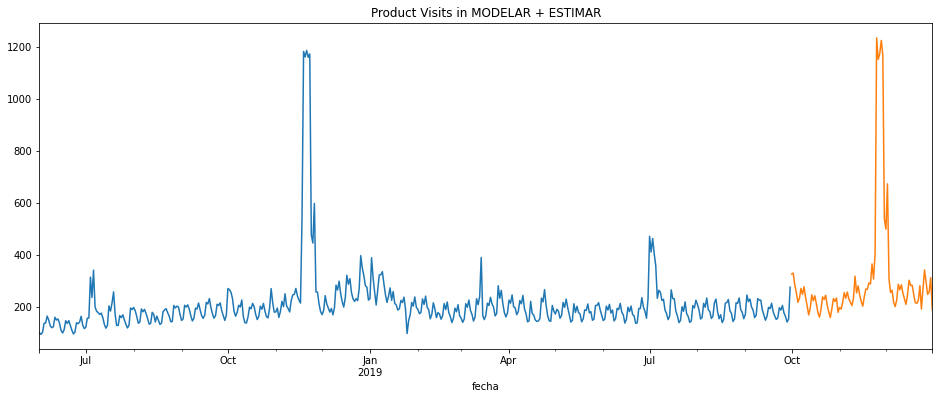

In [20]:
plt.figure(figsize=[16,6])
plt.title('Product Visits in MODELAR + ESTIMAR')
df_modelar.groupby('fecha').mean().visitas_scl.plot()
_ = df_estimar.groupby('fecha').mean().visitas_scl.plot()

# Machine Learning Pipeline

We will be using Keras to build a regression Neural Network to predict the target label. The steps will be as follows:

1. Time Series analysis of the Seasonality / Trend
    - Extract weekly seasonality
    - Extract month-of-the-year trend
1. Determine the X and y columns
2. Split our data in Train / Test datasets wtih 0.9 / 0.1 weights
3. Transform our data to be easier for the NN to process
4. Sanity check our data before we proceed
5. Define the NN model to use:
    - Layer types
    - Number of neurons per layer
    - Output layer
    - Optimization function
    - Target loss
6. Execute the NN training on a GPU



## TimeSeries Analysis and Features

As explained in the Exploratory script, we will be using TimeSeries concepts to exctract key insights and features for the ML prediction. We are interested in the seasonal decomposition of the data with a fequency of "one day".

This will show up as the "weekly variance" between mon-sun for `unidades_vendidas`, and we will insert that value as a new feature to help the model understand that the weekday is a big predictor of overall sales.

In adition, we will be using the "monthly" averaged trend as a new feature aswell to help the model narrow down even more between different months of the year.

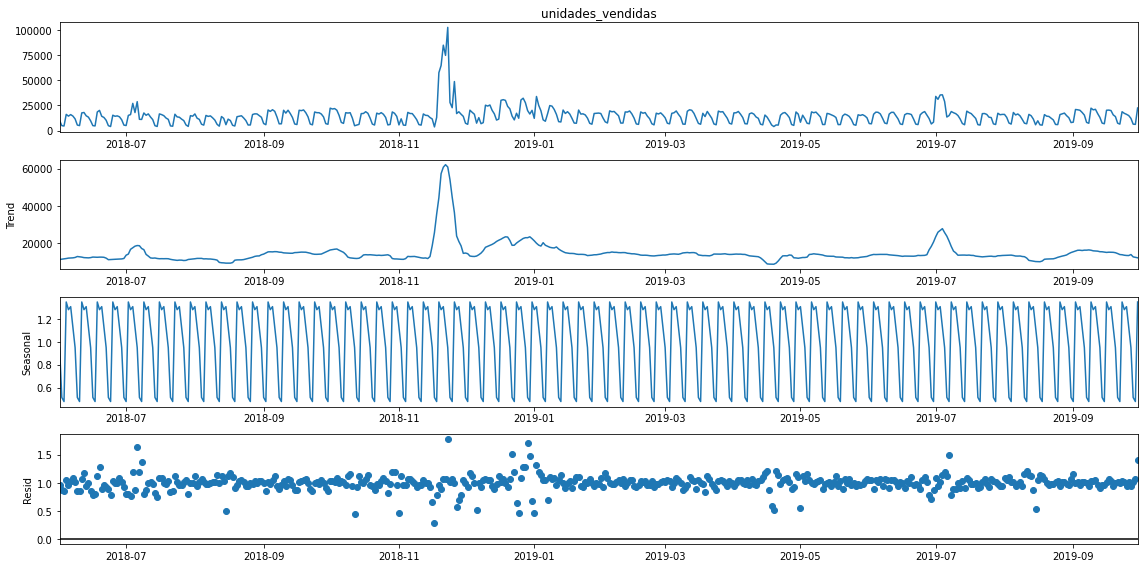

In [21]:
df_modelar_day = df_modelar.groupby('fecha').sum().asfreq('D')

ts_decompose = seasonal_decompose(df_modelar_day.unidades_vendidas, model='multiplicative', extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (16,8)})
ts_decompose.plot()
plt.show()

In [22]:
# Select Mon-Sun
ts_seasonal = ts_decompose.seasonal[3:10]

ts_trend = ts_decompose.trend.resample('M').mean()
ts_trend = ts_trend / ts_trend.mean()
# Select Jan-Dec
trend_month_year = pd.concat([ts_trend[7:], ts_trend[4:7]])

month_to_factor = dict(zip(range(12), trend_month_year))
weekday_to_factor = dict(zip(range(7), ts_seasonal))

df_modelar['ts_seasonal'] = df_modelar.fecha.dt.weekday.map(weekday_to_factor)
df_modelar['ts_trend'] = (df_modelar.fecha.dt.month-1).map(month_to_factor)

df_modelar[['fecha', 'id', 'ts_seasonal', 'ts_trend']][:3]

,fecha,id,ts_seasonal,ts_trend
0,2018-06-01,21972,0.948618,0.947512
1,2018-06-01,23910,0.948618,0.947512
2,2018-06-01,24306,0.948618,0.947512


### Per-product historical features

Since we are building a single model, it is a very good idea to de-normalize our data and include a "historical summary" of the line's product on each row of data. We are going to do this through calculating some statistical values for each product, and then adding them to the MODELAR dataframe.

The same products calculated with the df_modelar data will be inserted in the ESTIMAR data. In the future this needs to be a 12-month rolling calculation. That is, we should only take into consideration the last 12 months of data in order to keep these stats fresh enoguh.

In [23]:
product_std = dict()
product_mean = dict()
product_ratio = dict()
product_view_to_buy = dict()

for p in df_modelar.id.unique():
    df_p = df_modelar[df_modelar.id == p]
    product_std[p] = df_p.unidades_vendidas.std()
    product_mean[p] = df_p.unidades_vendidas.mean()
    product_ratio[p] = product_std[p] / product_mean[p]
    product_view_to_buy[p] = df_p.visitas_scl.mean() / df_p.unidades_vendidas.mean()

df_modelar['unidades_mean'] = df_modelar.id.map(product_mean)
df_modelar['unidades_std'] = df_modelar.id.map(product_std)
df_modelar['unidades_ratio'] = df_modelar.id.map(product_ratio)
df_modelar['view_buy_ratio'] = df_modelar.id.map(product_view_to_buy)

## Data handling - Train / Test Split

We are done with the data processing and engineering of features, we will now select our candidate features and begin to build our 4 train / test dataset:
1. X_train: Our training data
2. y_train: labels for the training data
3. X_test: Validation data
4. y_test: labels for the validation data

We are using a 90/10 split of data since we have so many datapoints. We can affort to take a big chunk of data for training so our model is as robust as it can be. We are sampling the data randominly, that is, we will be training with the entire interval of dates, and predicting in-interval. Since years are cyclical, we are confident this will perform well enough when we extrapolate 3 months into the future (ESTIMAR dataset).

In [24]:
from sklearn.model_selection import train_test_split

X_cols = [
    'campaña',
    'dia_atipico_neg', 'dia_atipico_neu', 'dia_atipico_pos',
    'estado_rotura', 'estado_no_rotura', 'estado_transito',
    'precio', 'visitas_scl',
    # Timeseries info
    'weekday_sin', 'weekday_cos',
    'month_sin', 'month_cos',
    'year_sin', 'year_cos',
    'ts_seasonal', 'ts_trend',
    # Product info
    'unidades_mean', 'unidades_std', 'unidades_ratio', 'view_buy_ratio' 
]

X_cols_cats = [
    'categoria_uno', 'categoria_dos'
]

X_cols_onehot_cats = [
    'categoria_uno__2',    'categoria_uno__3',    'categoria_uno__12',    'categoria_uno__9',
    'categoria_uno__1',    'categoria_uno__14',   'categoria_uno__11',
    'categoria_uno__6',    'categoria_uno__15',   'categoria_uno__5',    'categoria_uno__8',
    'categoria_uno__4',    'categoria_uno__7',

    'categoria_dos__0',    'categoria_dos__10',    'categoria_dos__101',    'categoria_dos__103',
    'categoria_dos__105',    'categoria_dos__108',    'categoria_dos__109',    'categoria_dos__114',
    'categoria_dos__115',    'categoria_dos__116',    'categoria_dos__120',    'categoria_dos__122',
    'categoria_dos__123',    'categoria_dos__124',    'categoria_dos__125',    'categoria_dos__127',
    'categoria_dos__131',    'categoria_dos__133',    'categoria_dos__135',    'categoria_dos__136',
    'categoria_dos__137',    'categoria_dos__14',    'categoria_dos__143',    'categoria_dos__144',
    'categoria_dos__145',    'categoria_dos__150',    'categoria_dos__155',    'categoria_dos__156',
    'categoria_dos__157',    'categoria_dos__158',    'categoria_dos__16',    'categoria_dos__160',
    'categoria_dos__161',    'categoria_dos__165',    'categoria_dos__170',    'categoria_dos__174',
    'categoria_dos__175',    'categoria_dos__179',    'categoria_dos__180',    'categoria_dos__182',
    'categoria_dos__183',    'categoria_dos__186',    'categoria_dos__188',    'categoria_dos__192',
    'categoria_dos__195',    'categoria_dos__197',    'categoria_dos__199',    'categoria_dos__2',
    'categoria_dos__20',    'categoria_dos__200',    'categoria_dos__201',    'categoria_dos__202',
    'categoria_dos__203',    'categoria_dos__205',    'categoria_dos__206',    'categoria_dos__207',
    'categoria_dos__212',    'categoria_dos__22',    'categoria_dos__221',    'categoria_dos__223',
    'categoria_dos__224',    'categoria_dos__226',    'categoria_dos__228',    'categoria_dos__229',
    'categoria_dos__23',    'categoria_dos__230',    'categoria_dos__233',    'categoria_dos__235',
    'categoria_dos__236',    'categoria_dos__237',    'categoria_dos__238',    'categoria_dos__239',
    'categoria_dos__243',    'categoria_dos__245',    'categoria_dos__247',    'categoria_dos__248',
    'categoria_dos__249',    'categoria_dos__253',    'categoria_dos__255',    'categoria_dos__256',
    'categoria_dos__258',    'categoria_dos__259',    'categoria_dos__263',    'categoria_dos__264',
    'categoria_dos__266',    'categoria_dos__267',    'categoria_dos__268',    'categoria_dos__269',
    'categoria_dos__27',    'categoria_dos__270',    'categoria_dos__271',    'categoria_dos__274',
    'categoria_dos__276',    'categoria_dos__277',    'categoria_dos__278',    'categoria_dos__28',
    'categoria_dos__282',    'categoria_dos__285',    'categoria_dos__286',    'categoria_dos__289',
    'categoria_dos__29',    'categoria_dos__292',    'categoria_dos__295',    'categoria_dos__296',
    'categoria_dos__298',    'categoria_dos__30',    'categoria_dos__303',    'categoria_dos__304',
    'categoria_dos__305',    'categoria_dos__307',    'categoria_dos__308',    'categoria_dos__312',
    'categoria_dos__314',    'categoria_dos__315',    'categoria_dos__316',    'categoria_dos__319',
    'categoria_dos__32',    'categoria_dos__323',    'categoria_dos__326',    'categoria_dos__329',
    'categoria_dos__333',    'categoria_dos__336',    'categoria_dos__338',    'categoria_dos__34',
    'categoria_dos__340',    'categoria_dos__341',    'categoria_dos__342',    'categoria_dos__343',
    'categoria_dos__36',    'categoria_dos__37',    'categoria_dos__38',    'categoria_dos__39',
    'categoria_dos__42',    'categoria_dos__43',    'categoria_dos__44',    'categoria_dos__45',
    'categoria_dos__46',    'categoria_dos__49',    'categoria_dos__5',    'categoria_dos__50',
    'categoria_dos__51',    'categoria_dos__57',    'categoria_dos__63',    'categoria_dos__65',
    'categoria_dos__66',    'categoria_dos__67',    'categoria_dos__69',    'categoria_dos__7',
    'categoria_dos__71',    'categoria_dos__72',    'categoria_dos__73',    'categoria_dos__75',
    'categoria_dos__76',    'categoria_dos__78',    'categoria_dos__8',    'categoria_dos__80',
    'categoria_dos__82',    'categoria_dos__84',    'categoria_dos__85',    'categoria_dos__86',
    'categoria_dos__92',    'categoria_dos__93',    'categoria_dos__95',    'categoria_dos__97'
]

y_cols = ['unidades_vendidas']

product_intersection = df_modelar.id.isin(df_estimar.id)

X = df_modelar[product_intersection][X_cols + X_cols_onehot_cats]
y = df_modelar[product_intersection][y_cols]

X = X.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

### Fit Scalers to the Train data

In [25]:
from sklearn.preprocessing import RobustScaler

# X Scaling
X_scaler = RobustScaler(quantile_range=[5,95])

X_train_scl = X_train
X_test_scl = X_test

X_cols_to_scl = ['precio', 'visitas_scl', 'unidades_std', 'unidades_mean', 'unidades_ratio', 'view_buy_ratio']

X_train_scl[X_cols_to_scl] = X_scaler.fit_transform(X_train[X_cols_to_scl])
X_test_scl[X_cols_to_scl] = X_scaler.transform(X_test[X_cols_to_scl])

# y scaling
y_scaler = RobustScaler(quantile_range=[5,95])
y_train_scl = y_scaler.fit_transform(y_train)
y_test_scl = y_scaler.transform(y_test)

In [26]:
# Inspect our data
print(X_train.shape)
print(X_test.shape)
X_train_scl.describe().round(2)

(1199188, 198)
(133244, 198)


,campaña,dia_atipico_neg,dia_atipico_neu,dia_atipico_pos,estado_rotura,estado_no_rotura,estado_transito,precio,visitas_scl,weekday_sin,...,categoria_dos__8,categoria_dos__80,categoria_dos__82,categoria_dos__84,categoria_dos__85,categoria_dos__86,categoria_dos__92,categoria_dos__93,categoria_dos__95,categoria_dos__97
count,1199188.00,1199188.00,1199188.00,1199188.0,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,...,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00,1199188.00
mean,0.00,0.03,0.87,0.1,0.09,0.90,0.01,0.12,0.19,-0.00,...,0.00,0.00,0.07,0.01,0.01,0.01,0.00,0.00,0.00,0.01
std,0.07,0.18,0.34,0.3,0.28,0.29,0.11,0.33,1.21,0.71,...,0.03,0.03,0.25,0.08,0.12,0.08,0.04,0.04,0.02,0.09
min,0.00,0.00,0.00,0.0,0.00,0.00,0.00,-0.25,-0.08,-0.97,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,-0.11,-0.06,-0.78,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,1.00,0.0,0.00,1.00,0.00,0.27,0.14,0.78,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.0,1.00,1.00,1.00,2.23,500.15,0.97,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


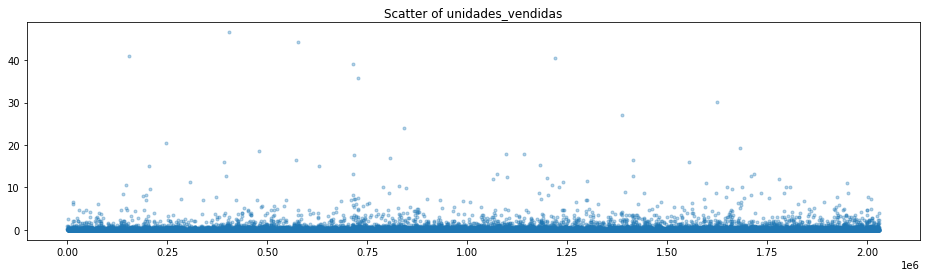

In [28]:
# Target variable spead
plt.figure(figsize=[16,4])
plt.title('Scatter of unidades_vendidas')
# plt.ylim([0,15])
plt.scatter(X_train.index[::50], y_train_scl[::50], marker=".", alpha=0.33)

# NN Model

### Scoring functions

In [15]:
from keras import backend as K
from tensorflow.python.ops import math_ops

y_mean_total = tf.constant(y_train_scl.mean(), dtype=np.float32)

def score_metric(y_true, y_pred):   
    mse = K.mean(K.square(y_true-y_pred))
    rrmse = K.sqrt(mse) / y_mean_total
    
    cf = K.mean(K.clip((y_pred-y_true)*1000, 0, 1))
    
    return 0.7 * rrmse + 0.3 * (1-cf)

def cf_loss(y_true, y_pred):
    error = tf.keras.losses.MAE(y_true, y_pred)
    
    cf = K.mean(K.clip((y_pred-y_true)*1000, 0, 1))
    
    return 0.9 * error + 0.1 * cf

## Neural Network architecture

We are choosing a Sequential NN architecture as it has performed the best in all of our training and testing. We use a relatively large ammount of parameters (6.5M) to train so we expect to capture a great deal of the data's character.

We are using LeakyRELU layers for our NN as they overall perform better than just _relu_, at the expense of a bit longer training time. We are still able to accelerate the entire training on our GPU resource.

In [29]:
from keras.layers import Dense, Dropout, BatchNormalization

FEAT_DIM = len(X.columns)
gc.collect()

dense_kwargs = {
    "activation":tf.keras.layers.LeakyReLU(alpha=0.2),
    "kernel_initializer":tf.keras.initializers.HeNormal()
}

model = models.Sequential()

model.add(Dense(FEAT_DIM*10, input_dim=FEAT_DIM, **dense_kwargs))
# model.add(Dropout(0.2))

model.add(Dense(FEAT_DIM*8, **dense_kwargs))
# model.add(Dropout(0.1))

# model.add(BatchNormalization())
model.add(Dense(FEAT_DIM*5, **dense_kwargs))
model.add(Dense(FEAT_DIM*4, **dense_kwargs))
model.add(Dense(FEAT_DIM*3, **dense_kwargs))
model.add(Dense(FEAT_DIM*2, **dense_kwargs))
# model.add(Dense(FEAT_DIM*16, activation='relu'))
# OUTPUT
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1980)              394020    
_________________________________________________________________
dense_1 (Dense)              (None, 1584)              3137904   
_________________________________________________________________
dense_2 (Dense)              (None, 990)               1569150   
_________________________________________________________________
dense_3 (Dense)              (None, 792)               784872    
_________________________________________________________________
dense_4 (Dense)              (None, 594)               471042    
_________________________________________________________________
dense_5 (Dense)              (None, 396)               235620    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3

### Neural Network Training

We decided against training with an aproximation of the "real" score function as it was giving us unstable training (probably due to the step function for `casos favorables`)

We are using early stopping to stop the NN from training for too long if it does not improve for a number of epochs.
Finally we store the best model at each step as scored in the validation dataset (data never seen by the NN).

In [30]:
# Early Stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Store best model
mc = keras.callbacks.ModelCheckpoint('best_model_old.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.compile(loss="mae", optimizer='adam', metrics=[])

history = model.fit(X_train_scl, y_train_scl, epochs=1000, batch_size=256,
    callbacks=[es, mc],
    validation_data=(X_test_scl, y_test_scl)
)

Epoch 1/1000
4683/4685 [============================>.] - ETA: 0s - loss: 0.2086
Epoch 00001: val_loss improved from inf to 0.18031, saving model to best_model_old.h5
4685/4685 [==============================] - 24s 5ms/step - loss: 0.2086 - val_loss: 0.1803
Epoch 2/1000
4685/4685 [==============================] - ETA: 0s - loss: 0.1828
Epoch 00002: val_loss improved from 0.18031 to 0.17711, saving model to best_model_old.h5
4685/4685 [==============================] - 24s 5ms/step - loss: 0.1828 - val_loss: 0.1771
Epoch 3/1000
4681/4685 [============================>.] - ETA: 0s - loss: 0.1956
Epoch 00003: val_loss improved from 0.17711 to 0.17423, saving model to best_model_old.h5
4685/4685 [==============================] - 23s 5ms/step - loss: 0.1956 - val_loss: 0.1742
Epoch 4/1000
4678/4685 [============================>.] - ETA: 0s - loss: 0.1769
Epoch 00004: val_loss did not improve from 0.17423
4685/4685 [==============================] - 23s 5ms/step - loss: 0.1769 - val_loss

## Inspecting the NN training results

This plot will help us identify if our NN is overfitting or if the training stalled. We can observe that the NN converges rather quickly but the dataset is very resistent to over-fitting.

This is why we decided to exclude the "Dropout" layers in our NN architecture, as we didn't see any overfitting of the data. Towards the end the NN does it's best to learn a bit more but we are pobably reaching the limit of this architecture and the data available to us.

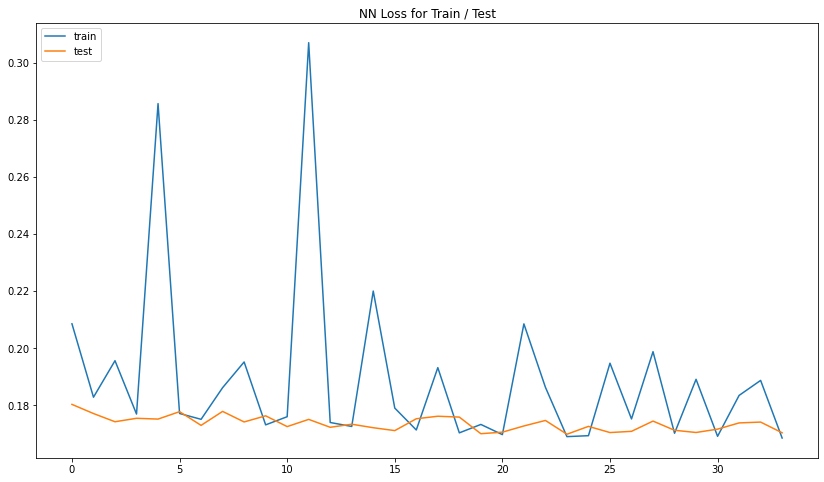

In [31]:
plt.figure(figsize=[14,8])
# plt.ylim((0.85,0.98))

plt.title('NN Loss for Train / Test')

train_acc = history.history['loss'][:]
test_acc = history.history['val_loss'][:]

plt.plot(train_acc)
plt.plot(test_acc)
# plt.plot([max(train_acc)] * len(train_acc))
# plt.plot([max(test_acc)] * len(test_acc))

plt.legend(['train', 'test'], loc='upper left')

## Model Scoring and Validation

Before we execute our model with the `Estimar` dataset, lets check the expected performance of our model. We want to center our attention to two aspects:

1. General predictive power across the entire year
2. Predictive score around the interest interval of Black friday and Christmas.
    - This will be the most correlated value to our expected `Estimar` score.

### Scoring Functions

These were defined in the documentation for this project.

In [32]:
def rrmse(y,yhat):
    return np.sqrt(np.sum(np.power(y-yhat,2))/y.shape[0])/y.mean()

def cf(y,yhat):
    no_rotura=np.where(yhat >= y, 1, 0)
    return no_rotura.mean()

def score(y,yhat):
    return (0.7*rrmse(y,yhat))+(.3*(1-cf(y,yhat)))

#### Use Trained model as is

In [38]:
# trained_model = model
y_hat = model.predict(test_data)
y_hat_real = y_scaler.inverse_transform(y_hat)
y_hat_real[y_hat_real < 0] = 0

#### Load Best model

In [33]:
from keras.models import load_model

# model = load_model('best_model.h5', compile=False)
model = load_model('best_model_old.h5', compile=False, custom_objects={'LeakyReLU':tf.keras.layers.LeakyReLU})

y_hat = model.predict(X_test)
y_hat_real = y_scaler.inverse_transform(y_hat)
y_hat_real[y_hat_real < 0] = 0

### Bruteforce Optimum Transformation Parameters

Since we were unable to include the "score" in our training function for the NN, we have deviced an aditional ML process to search for the optimal transformation that can be applied to the NN output to maximize the `score` function.

We are using an iterative linear-space search that explores a manifold and finds the global optima parameters to use for a final transformation function `optimize_transform`.

We expect this to be the very last step to maximize the score.

In [34]:
best_score = 999

for mul in np.linspace(0.8,1.2,20):
    for add in np.linspace(0,5,20):
        for pw in np.linspace(0.95,1.20,20):
            
            yhr = (np.power(y_hat_real, pw) * mul + add).round(0)
            scr = score(y_test.values, yhr)
            
            if scr < best_score:
                best_score = scr
                print("*%.2f +%.2f ^%.2f = %.5f "%(mul, add, pw, scr))
                _pw = pw
                _mul = mul
                _add = add

def optimize_transform(y_pred):
    return (np.power(y_pred, _pw) * _mul + _add).round(0)


*0.80 +0.00 ^0.95 = 2.24710 
*0.80 +0.00 ^0.96 = 2.21257 
*0.80 +0.00 ^0.98 = 2.17839 
*0.80 +0.00 ^0.99 = 2.14434 
*0.80 +0.00 ^1.00 = 2.11188 
*0.80 +0.00 ^1.02 = 2.08076 
*0.80 +0.00 ^1.03 = 2.05258 
*0.80 +0.00 ^1.04 = 2.02819 
*0.80 +0.00 ^1.06 = 2.00919 
*0.80 +0.00 ^1.07 = 1.99659 
*0.80 +0.00 ^1.08 = 1.99229 
*0.80 +0.26 ^1.07 = 1.99028 
*0.80 +0.26 ^1.08 = 1.98673 
*0.80 +0.53 ^1.07 = 1.98006 
*0.80 +0.53 ^1.08 = 1.97713 
*0.80 +0.79 ^1.07 = 1.97499 
*0.80 +0.79 ^1.08 = 1.97226 
*0.80 +1.05 ^1.07 = 1.97062 
*0.80 +1.05 ^1.08 = 1.96830 
*0.80 +1.32 ^1.07 = 1.96650 
*0.80 +1.32 ^1.08 = 1.96500 
*0.80 +2.11 ^1.07 = 1.96440 
*0.80 +2.11 ^1.08 = 1.96381 
*0.80 +2.37 ^1.07 = 1.96136 
*0.80 +2.63 ^1.07 = 1.95392 
*0.80 +2.89 ^1.07 = 1.95244 
*0.80 +3.16 ^1.07 = 1.95117 
*0.80 +3.42 ^1.07 = 1.95028 
*0.82 +2.89 ^1.07 = 1.95019 
*0.82 +3.16 ^1.07 = 1.94936 
*0.82 +3.42 ^1.07 = 1.94858 
*0.86 +2.89 ^1.06 = 1.94846 
*0.86 +3.16 ^1.06 = 1.94739 
*0.88 +2.89 ^1.06 = 1.94707 
*0.88 +3.16 ^1

### Generate Predictions for Validation

We will now store our predictions into a dataframe for further analysis.

In [35]:
df_y_hat = pd.DataFrame()

df_y_hat['id'] = df_modelar.loc[X_test.index].id
df_y_hat['fecha'] = df_modelar.loc[X_test.index].fecha
# df_y_hat['visitas'] = X_test.visitas_scl
df_y_hat['y_test'] = y_test
df_y_hat['y_hat_raw'] = y_hat_real
df_y_hat['y_hat_opt'] = optimize_transform(y_hat_real)

#### General Error over the Range

To get a quick overview of how our model is performing, we will plot our estimate for the entire interval (orange) against the real data (blue).

On the first graph, we can observe that our NN predictions are underestimating consistently across the range. This is why we had to include a secondary step to optimize this prediction.

On the second graph we've plotted our optimized prediction. We can see we are now "enveloping" the real data very closely across the range, never over-estimating significantly, and matching the peaks very closely.

('entire interval score (NN/Optimized)', 2.007994066169117, 1.9418366357610066)

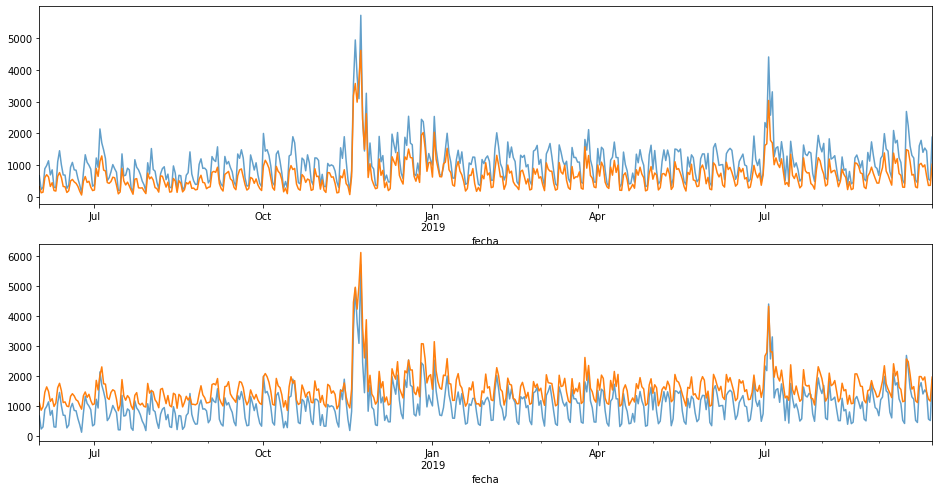

In [37]:
plt.plot(figsize=[16,8])

aggregates = df_y_hat.groupby('fecha').sum()

plt.subplot(2,1,1)
aggregates.y_test.plot(alpha=0.7)
aggregates.y_hat_raw.plot(alpha=1)

plt.subplot(2,1,2)
aggregates.y_test.plot(alpha=0.7)
aggregates.y_hat_opt.plot(alpha=1)

"entire interval score (NN/Optimized)", score(df_y_hat.y_test, df_y_hat.y_hat_raw), score(df_y_hat.y_test, df_y_hat.y_hat_opt)

#### Black Friday OOS Test

Lets take a look now at the Black friday interval (the same interval as the ESTIMAR dataset but one year prior) to see what we can expect to see in our ESTIMAR score.

Looking at the real data (blue) against or prediction (orange) we can say we are very happy on how the shape matches up. The estimated score is also performing as well as the general case, so we can see our model being consistent across the range.

('black friday score', 1.9478466034239132)

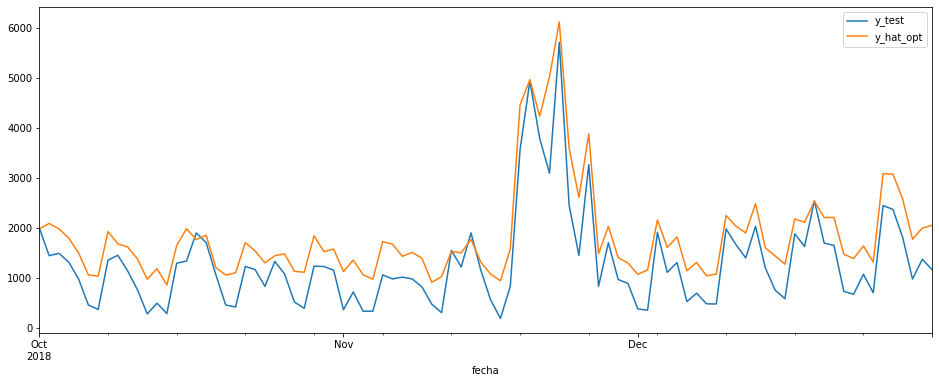

In [38]:
# Black friday dates
bf_index = (df_y_hat.fecha >= datetime(2018,10,1)) & (df_y_hat.fecha <= datetime(2018,12,31))

df_bf = df_y_hat[bf_index]

df_bf.groupby('fecha').sum()[['y_test','y_hat_opt']].plot(figsize=[16,6])

"black friday score", score(df_bf.y_test, df_bf.y_hat_opt)

# Generate final predictions

Apply the same transformations to the `Estimar` dataset to match the training data and generate predictions for it. We adjust the final output by +1 due to the `CF` factor.

In [39]:
df_estimar.shape

(212841, 197)

In [40]:
# Time Series data
df_estimar['ts_seasonal'] = df_estimar.fecha.dt.weekday.map(weekday_to_factor)
df_estimar['ts_trend'] = (df_estimar.fecha.dt.month-1).map(month_to_factor)

In [41]:
# Per Product Stats
df_estimar['unidades_mean'] = df_estimar.id.map(product_mean)
df_estimar['unidades_std'] = df_estimar.id.map(product_std)
df_estimar['unidades_ratio'] = df_estimar.id.map(product_ratio)
df_estimar['view_buy_ratio'] = df_estimar.id.map(product_view_to_buy)

In [42]:
# Build X_estimar
X_estimar = df_estimar[X_cols + X_cols_onehot_cats]
X_estimar[X_cols_to_scl] = X_scaler.transform(X_estimar[X_cols_to_scl])

X_estimar = X_estimar.astype(np.float32)

# int_cols = ['id_dim']
# X_estimar[int_cols] = X_estimar[int_cols].astype(np.int32)

X_estimar.shape

(212841, 198)

In [43]:
# estimar_data = [
#     X_estimar.id_dim,
# #     X_estimar.categoria_uno_int,
# #     X_estimar.categoria_dos,
#     X_estimar[X_estimar.columns.drop(['id_dim'])]
# ]

# y_estimar = model.predict(estimar_data)
y_estimar = model.predict(X_estimar)
y_estimar.shape

(212841, 1)

In [44]:
y_estimar = y_scaler.inverse_transform(y_estimar)
y_estimar[y_estimar < 0] = 0
y_estimar = optimize_transform(y_estimar)

In [45]:
df_entrega = df_estimar[['fecha','id']]

df_entrega['unidades'] = y_estimar.astype(np.int32)

# df_entrega.loc[df_entrega.fecha.dt.year == 2019, "fecha"] = df_entrega.fecha + pd.offsets.DateOffset(year=2016)
df_entrega[:5]

,fecha,id,unidades
0,2019-10-01,21972,3
1,2019-10-01,23910,3
2,2019-10-01,27144,4
3,2019-10-01,30014,3
4,2019-10-01,30522,3


### Spot-checking Product predictions

Now that we have actually generated the predictions for the ESTIMAR interval, lets do some spot checking of some of the products to see how well we are matching the shape, frequency and overall volume.

We can see that our predictions look very realistic according to the historical data and what we know about the ESTIMAR interval. That is, we are predicting the black friday campaing in particular, a very complex period to capture correctly.

<AxesSubplot:xlabel='fecha'>

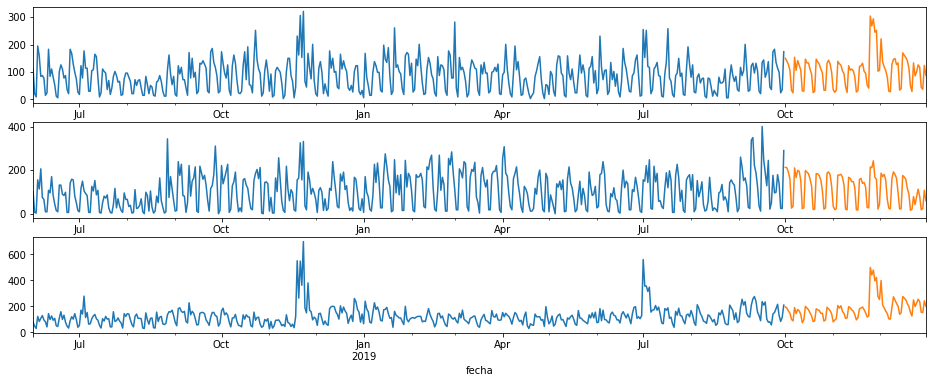

In [54]:
plt.figure(figsize=[16,6])
plt.title('Spot checking Products')

plt.subplot(3,1,1)
df_modelar[df_modelar.id == 171826].groupby('fecha').mean().unidades_vendidas.plot()
df_entrega[df_entrega.id == 171826].groupby('fecha').mean().unidades.plot()

plt.subplot(3,1,2)
df_modelar[df_modelar.id == 86096].groupby('fecha').mean().unidades_vendidas.plot()
df_entrega[df_entrega.id == 86096].groupby('fecha').mean().unidades.plot()

plt.subplot(3,1,3)
df_modelar[df_modelar.id == 171840].groupby('fecha').mean().unidades_vendidas.plot()
df_entrega[df_entrega.id == 171840].groupby('fecha').mean().unidades.plot()

## Delivery CSV

In [55]:
df_entrega.columns = ['FECHA', 'ID', 'UNIDADES']
df_entrega.to_csv(
    'Entrega 2021-04-14/Atmira_Universitat de Barcelona_Equip Autoestima.txt',
    sep='|', index=False, date_format="%d/%m/%Y"
)